# Topic Modeling: A Naive Example

## What is Topic Modeling?

- Topic modeling is an **unsupervised** learning method, whose objective is to extract the underlying semantic patterns among a collection of texts. These underlying semantic structures are commonly referred to as **topics** of the corpus.
- In particular, topic modeling first extracts features from the words in the documents and use mathematical structures and frameworks like matrix factorization and SVD (Singular Value Decomposition) to identify clusters of words that share greater semantic coherence.
- These clusters of words form the notions of *topics*.
- Meanwhile, the mathematical framework will also determine the distribution of these **topics** for each document.


- In short, an intuitive understanding of Topic Modeling:
    - Each **document** consists of several **topics** (a distribution of different topics).
    - Each topic is connected to particular groups of **words** (a distribution of different words).

## Flowchart for Topic Modeling

![](../images/topic-modeling-pipeline.jpeg)

## Data Preparation and Preprocessing

### Import Necessary Dependencies and Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 100
# %matplotlib inline

### Simple Corpus


- We will be using again a simple corpus for illustration.
- It is a corpus consisting of eight documents, each of which consists of a simple sentence.

In [2]:
corpus = [
    'The sky is blue and beautiful.', 'Love this blue and beautiful sky!',
    'The quick brown fox jumps over the lazy dog.',
    "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
    'I love green eggs, ham, sausages and bacon!',
    'The brown fox is quick and the blue dog is lazy!',
    'The sky is very blue and the sky is very beautiful today',
    'The dog is lazy but the brown fox is quick!'
]
labels = [
    'weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather',
    'animals'
]

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals


### Simple Text Pre-processing

- Depending on the nature of the raw corpus data, we may need to implement more specific steps in text preprocessing.
- In our current naive example, we consider:
    - removing symbols and punctuations
    - normalizing the letter case
    - stripping unnecessary/redundant whitespaces
    - removing stopwords (which requires an intermediate tokenization step)


:::{tip}

Other important considerations in text preprocessing include:
- whether to remove hyphens
- whether to lemmatize word forms
- whether to stemmatize word forms
- whether to remove short word tokens
- whether to remove unknown words (e.g., words not listed in WordNet)
- whether to remove functional words (e.g., including only content words, such as nouns, verbs, adjectives)

:::

In [3]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')


def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I | re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokeanize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc


normalize_corpus = np.vectorize(normalize_document)

In [4]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

- The `norm_corpus` will be the input for our next step, text vectorization.

## Text Vectorization

### Bag of Words Model

- In topic modeling, the simplest way of text vectorization is to adopt the feature-based Bag-of-Words model.
- Recap of the characteristics of BOW model
    - It is a naive way to vectorize texts into numeric representations using their word frequency lists
    - The sequential order of words in the text is naively ignored.
    - We can filter the document-by-word matrix in many different ways (Please see the lecture notes on [Lecture Notes: Text Vectorization](../nlp/text-vec-traditional.ipynb)
- Please use the **count-based** vectorizer for topic modeling because most of the topic modeling algorithms will take care of the weightings automatically during the mathematical computing.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
# get bag of words features in sparse format
cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix

<8x20 sparse matrix of type '<class 'numpy.int64'>'
	with 42 stored elements in Compressed Sparse Row format>

In [6]:
# view dense representation
# warning might give a memory error if data is too big
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]])

In [7]:
# get all unique words in the corpus
vocab = cv.get_feature_names_out()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,bacon,beans,beautiful,blue,breakfast,brown,dog,eggs,fox,green,ham,jumps,kings,lazy,love,quick,sausages,sky,toast,today
0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0,0
3,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0
4,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0
5,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0
6,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1
7,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0


## Latent Dirichlet Allocation

### Intuition of LDA

- Latent Dirichlet [diʀiˈkleː] Allocation learns the relationships between **words**, **topics**, and **documents** by assuming documents are generated by a particular probabilistic model.
- A topic in LDA is a multinomial distribution over the words in the vocabulary of the corpus. (That is, given a topic, it's more likely to see specific sets of words).

- What LDA gives us is:
    - Which words are more likely to be connected to specific topics? (Topic by Word Matrix)
    - Which topics are more likely to be connected to specific documents? (Document by Topic Matrix)
    

- To interpret a topic in LDA, we examine the ranked list of the most probable (top N) words in that topic.
- Common words in the corpus often appear near the top of the words for each topic, which makes it hard to differentiate the meanings of these topics sometimes.
- When inspecting the word rankings for each topic, we can utilize two types of information provided by LDA:
    - The frequencies of the words under each topic
    - The exclusivity of the words to the topic (i.e., the degree to which the word appears in that particular topic to the exclusion of others).

### Building LDA Model

- We should use `CountVectorizer` when fitting LDA instead of `TfidfVectorizer` because LDA is based on term count and document count. 
- Fitting LDA with `TfidfVectorizer` will result in rare words being dis-proportionally sampled. 
- As a result, they will have greater impact and influence on the final topic distribution.

In [8]:
%%time
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=3, max_iter=10000, random_state=0)
doc_topic_matrix = lda.fit_transform(cv_matrix)

CPU times: user 5.28 s, sys: 25.2 ms, total: 5.3 s
Wall time: 5.32 s


### Model Performance Metrics

- We can diagnose the model performance using **perplexity** and **log-likelihood**.
    - The higher the log-likelihood, the better.
    - The lower the perplexity, the better.

In [9]:
# log-likelihood
print(lda.score(cv_matrix))
# perplexity
print(lda.perplexity(cv_matrix))

-138.91263303644246
25.29296641284209


## Interpretation

- To properly interpret the results provided by LDA, we need to get two important matrices:
    - **Document-by-Topic** Matrix: This is the matrix returned by the `LatentDirichletAllocation` object when we `fit_transform()` the model with the data.
    - **Word-by-Topic** Matrix: We can retrieve this matrix from a fitted `LatentDirichletAllocation` object. i.e., `LatentDirichletAllocation.components_`

### Document-by-Topic Matrix

- In **Document-by-Topic** matrix, we can see how each document in the corpus (**row**) is connected to each **topic**.
- In particular, the numbers refer to the probability value of a specific document being connected to a particular topic.

In [10]:
## doc-topic matrix
doc_topic_df = pd.DataFrame(doc_topic_matrix, columns=['T1', 'T2', 'T3'])
doc_topic_df

,T1,T2,T3
0,0.832191,0.083480,0.084329
1,0.863554,0.069100,0.067346
2,0.047794,0.047776,0.904430
3,0.037243,0.925559,0.037198
4,0.049121,0.903076,0.047802
5,0.054902,0.047778,0.897321
6,0.888287,0.055697,0.056016
7,0.055704,0.055689,0.888607


### Topic-by-Word Matrix

- In **Topic-by-Word** matrix, we can see how each topic (**row**) is connected to each word in the BOW.
- In particular, the numbers refer to the importance of the word with respect to each topic.

In [11]:
topic_word_matrix = lda.components_

In [12]:
pd.DataFrame(topic_word_matrix, columns=vocab)

,bacon,beans,beautiful,blue,breakfast,brown,dog,eggs,fox,green,ham,jumps,kings,lazy,love,quick,sausages,sky,toast,today
0,0.333699,0.333647,3.332365,3.373774,0.333647,0.333891,0.333891,0.333699,0.333891,0.333793,0.333699,0.333814,0.333647,0.333891,1.330416,0.333891,0.333699,4.332439,0.333647,1.332558
1,2.332696,1.332774,0.333853,0.334283,1.332774,0.333761,0.333761,2.332696,0.333761,1.332543,2.332696,0.333767,1.332774,0.333761,1.335461,0.333761,2.332696,0.333812,1.332774,0.333744
2,0.333606,0.333579,0.333782,1.291942,0.333579,3.332347,3.332347,0.333606,3.332347,0.333664,0.333606,1.332419,0.333579,3.332347,0.334123,3.332347,0.333606,0.333749,0.333579,0.333698


- We can transpose the matrix for clarity of inspection.

In [13]:
pd.DataFrame(np.transpose(topic_word_matrix), index=vocab)

,0,1,2
bacon,0.333699,2.332696,0.333606
beans,0.333647,1.332774,0.333579
beautiful,3.332365,0.333853,0.333782
blue,3.373774,0.334283,1.291942
breakfast,0.333647,1.332774,0.333579
brown,0.333891,0.333761,3.332347
dog,0.333891,0.333761,3.332347
eggs,0.333699,2.332696,0.333606
fox,0.333891,0.333761,3.332347
green,0.333793,1.332543,0.333664


### Interpreting the Meanings of Topics

- This is the most crucial step in topic modeling. The LDA does not give us a label for each topic.
- It is the analyst who determines the **meanings** of the topics.
- These decisions are based on the words under each topic that show high importance weights.

In [14]:
## This function sorts the words importances under each topic
## and the selectional criteria include (a) ranks based on weights, or (b) cutoff on weights
def get_topics_meanings(tw_m,
                        vocab,
                        display_weights=False,
                        topn=5,
                        weight_cutoff=0.6):
    for i, topic_weights in enumerate(tw_m):  ## for each topic row
        topic = [(token, np.round(weight, 2))
                 for token, weight in zip(vocab, topic_weights)
                 ]  ## zip (word, importance_weight)
        topic = sorted(topic,
                       key=lambda x: -x[1])  ## rank words according to weights
        if display_weights:
            topic = [item for item in topic if item[1] > weight_cutoff
                     ]  ## output words whose weights > 0.6
            print(f"Topic #{i} :\n{topic}")
            print("=" * 20)
        else:
            topic_topn = topic[:topn]
            topic_topn = ' '.join([word for word, weight in topic_topn])
            print(f"Topic #{i} :\n{topic_topn}")
            print('=' * 20)

- To use the above function:
  - If we are to display the weights of words, then we need to specify the `weight_cutoff`.
  - If we are to display only the top N words, then we need to specify the `topn`.

In [15]:
get_topics_meanings(topic_word_matrix,
                    vocab,
                    display_weights=True,
                    weight_cutoff=2)

Topic #0 :
[('sky', 4.33), ('blue', 3.37), ('beautiful', 3.33)]
Topic #1 :
[('bacon', 2.33), ('eggs', 2.33), ('ham', 2.33), ('sausages', 2.33)]
Topic #2 :
[('brown', 3.33), ('dog', 3.33), ('fox', 3.33), ('lazy', 3.33), ('quick', 3.33)]


In [16]:
get_topics_meanings(topic_word_matrix, vocab, display_weights=False, topn=3)

Topic #0 :
sky blue beautiful
Topic #1 :
bacon eggs ham
Topic #2 :
brown dog fox


## Topics in Documents

- After we determine the meanings of the topics, we can now analyze how each document is connected to these topics.
- That is, we can now look at the **Document-by-Topic** Matrix.

In [17]:
topics = ['weather', 'food', 'animal']
doc_topic_df.columns = topics
doc_topic_df['corpus'] = norm_corpus
doc_topic_df

,weather,food,animal,corpus
0,0.832191,0.083480,0.084329,sky blue beautiful
1,0.863554,0.069100,0.067346,love blue beautiful sky
2,0.047794,0.047776,0.904430,quick brown fox jumps lazy dog
3,0.037243,0.925559,0.037198,kings breakfast sausages ham bacon eggs toast beans
4,0.049121,0.903076,0.047802,love green eggs ham sausages bacon
5,0.054902,0.047778,0.897321,brown fox quick blue dog lazy
6,0.888287,0.055697,0.056016,sky blue sky beautiful today
7,0.055704,0.055689,0.888607,dog lazy brown fox quick


- We can visualize the topics distribution for each document using stack plot.

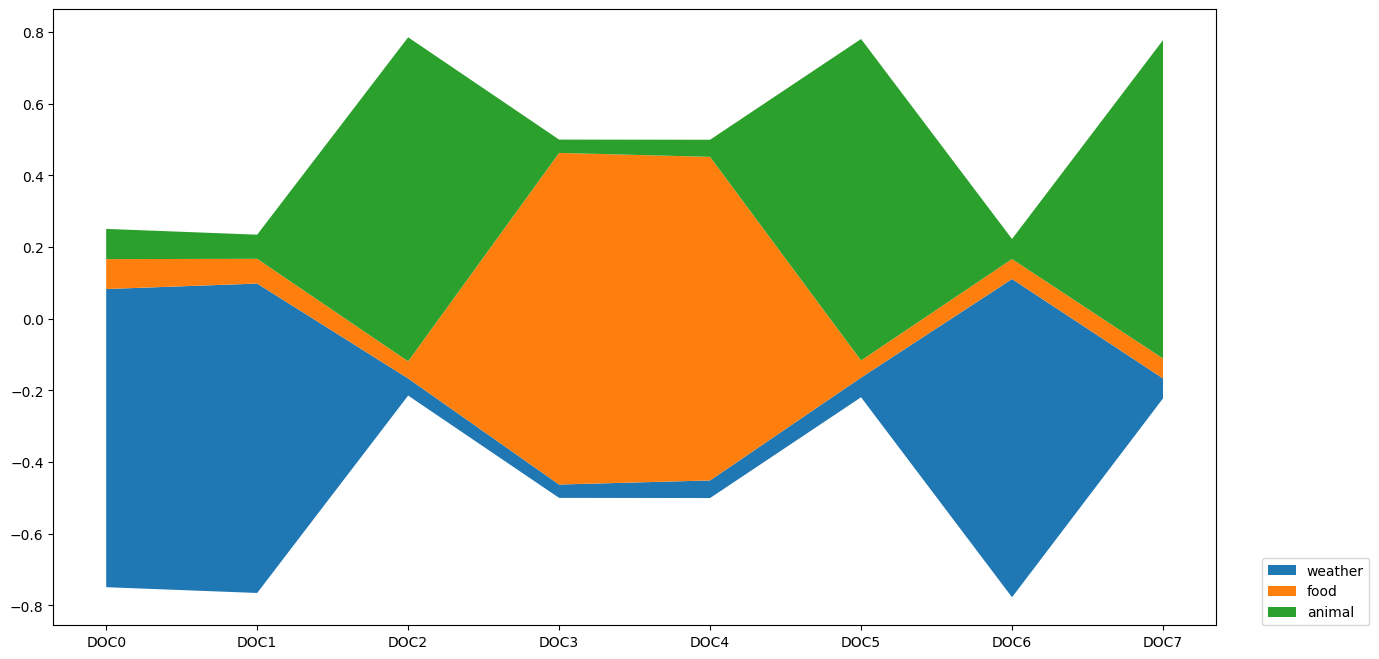

In [18]:
x_axis = ['DOC' + str(i) for i in range(len(norm_corpus))]
y_axis = doc_topic_df[['weather', 'food', 'animal']]

fig, ax = plt.subplots(figsize=(15, 8))

# Plot a stackplot - https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/stackplot_demo.html
ax.stackplot(x_axis, y_axis.T, baseline='wiggle', labels=y_axis.columns)

# Move the legend off of the chart
ax.legend(loc=(1.04, 0))

## Clustering documents using topic model features

In [19]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_topic_matrix)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,2
1,Love this blue and beautiful sky!,weather,2
2,The quick brown fox jumps over the lazy dog.,animals,1
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,0
4,"I love green eggs, ham, sausages and bacon!",food,0
5,The brown fox is quick and the blue dog is lazy!,animals,1
6,The sky is very blue and the sky is very beautiful today,weather,2
7,The dog is lazy but the brown fox is quick!,animals,1


## Visualizing Topic Models

In [20]:
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.lda_model ## for sklearn LDA; if gensim, use `pyLDAvis.gensim`
import dill
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pyLDAvis.enable_notebook()

In [21]:
## This block is to fix the pyLDAvis style issue
from IPython.core.display import display, HTML
display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))


In [22]:
cv_matrix = cv.fit_transform(norm_corpus)
pyLDAvis.lda_model.prepare(lda, cv_matrix, cv, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.008446  0.169018       1        1  38.698580
1      0.134621 -0.085246       2        1  33.674475
0     -0.126175 -0.083772       3        1  27.626945, topic_info=         Term      Freq     Total Category  logprob  loglift
17        sky  3.000000  3.000000  Default  20.0000  20.0000
2   beautiful  2.000000  2.000000  Default  19.0000  19.0000
3        blue  3.000000  3.000000  Default  18.0000  18.0000
13       lazy  2.000000  2.000000  Default  17.0000  17.0000
5       brown  2.000000  2.000000  Default  16.0000  16.0000
..        ...       ...       ...      ...      ...      ...
13       lazy  0.212021  2.793123   Topic3  -4.0259  -1.2919
8         fox  0.212021  2.793123   Topic3  -4.0259  -1.2919
15      quick  0.212021  2.793123   Topic3  -4.0259  -1.2919
6         dog  0.212021  2.793123   Topic3  -4.0259  -1.2919
5       brown  0.212021  2.793123   Topic3  -4.0259  -1.2919

[80 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         2  0.961000      bacon
1         2  0.724338      beans
2         3  0.773676  beautiful
3         1  0.304268       blue
3         3  0.608536       blue
4         2  0.724338  breakfast
5         1  0.716044      brown
6         1  0.716044        dog
7         2  0.961000       eggs
8         1  0.716044        fox
9         2  0.724342      green
10        2  0.961000        ham
11        1  0.722361      jumps
12        2  0.724338      kings
13        1  0.716044       lazy
14        2  0.496084       love
14        3  0.496084       love
15        1  0.716044      quick
16        2  0.961000   sausages
17        3  0.931661        sky
18        2  0.724338      toast
19        3  0.760429      today, R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

## Hyperparameter Tuning

- One thing we haven't made explicit is that the **number of topics** so far has been pre-determined. 
- How to find the optimal number of topics can be challenging in topic modeling.
- We can take this as a hyperparameter of the model and use **Grid Search** to find the most optimal number of topics.
- Similarly, we can fine tune the other hyperparameters of LDA as well (e.g., `learning_decay`).

- `learning_method`: The default is `batch`; that is, use all training data for parameter estimation. If it is `online`, the model will update the parameters on a token by token basis.
- `learning_decay`: If the `learning_method` is `online`, we can specify a parameter that controls learning rate in the online learning method (usually set between (0.5, 1.0]). 

:::{tip}

Doing Grid Search with LDA models can be very slow. There are some other topic modeling algorithms that are a lot faster. Please refer to Sarkar (2019) Chapter 6 for more information.

:::

### Grid Search for Topic Number

In [23]:
%%time
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

# Options to try with our LDA
# Beware it will try *all* of the combinations, so it'll take ages
search_params = {'n_components': range(3,8), 'learning_decay': [.5, .7]}

# Set up LDA with the options we'll keep static
model = LatentDirichletAllocation(learning_method='online', ## `online` for large datasets
                                  max_iter=10000,
                                  random_state=0)

# Try all of the options
gridsearch = GridSearchCV(model,
                          param_grid=search_params,
                          n_jobs=-1,
                          verbose=1)
gridsearch.fit(cv_matrix)

## Save the best model
best_lda = gridsearch.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


CPU times: user 6.55 s, sys: 49.7 ms, total: 6.6 s
Wall time: 54.5 s


In [24]:
# What did we find?
print("Best Model's Params: ", gridsearch.best_params_)
print("Best Log Likelihood Score: ", gridsearch.best_score_)
print('Best Model Perplexity: ', best_lda.perplexity(cv_matrix))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 3}
Best Log Likelihood Score:  -50.41087449871125
Best Model Perplexity:  25.292966407265162


### Examining the Grid Search Results

In [25]:
cv_results_df = pd.DataFrame(gridsearch.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_decay,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,13.603249,1.602856,0.001377,0.000117,0.5,3,"{'learning_decay': 0.5, 'n_components': 3}",-45.022881,-73.947624,-60.589126,-37.947945,-34.546797,-50.410874,14.789181,1
1,15.606485,3.031277,0.001455,0.000176,0.5,4,"{'learning_decay': 0.5, 'n_components': 4}",-49.145597,-82.726222,-65.081852,-42.126555,-37.038041,-55.223653,16.689929,4
2,12.842889,1.150975,0.001275,0.000214,0.5,5,"{'learning_decay': 0.5, 'n_components': 5}",-50.024619,-86.229447,-68.803221,-44.942217,-42.246234,-58.449148,16.702671,5
3,14.287387,1.691120,0.001440,0.000140,0.5,6,"{'learning_decay': 0.5, 'n_components': 6}",-52.609495,-92.798988,-76.277660,-48.051613,-50.126104,-63.972772,17.644821,8
4,13.265179,1.048562,0.001409,0.000144,0.5,7,"{'learning_decay': 0.5, 'n_components': 7}",-54.878310,-99.179301,-75.026422,-50.917763,-46.539680,-65.308295,19.543899,10
5,14.578954,1.979207,0.001500,0.000149,0.7,3,"{'learning_decay': 0.7, 'n_components': 3}",-45.022882,-73.947624,-60.589126,-37.947946,-34.546797,-50.410875,14.789181,2
6,15.057266,1.961181,0.001391,0.000309,0.7,4,"{'learning_decay': 0.7, 'n_components': 4}",-49.145597,-81.939131,-65.081852,-42.126555,-37.038041,-55.066235,16.431495,3
7,14.238861,1.063881,0.001462,0.000167,0.7,5,"{'learning_decay': 0.7, 'n_components': 5}",-50.024619,-86.229447,-68.803221,-44.942217,-42.246234,-58.449148,16.702671,6
8,13.910200,0.538017,0.001009,0.000260,0.7,6,"{'learning_decay': 0.7, 'n_components': 6}",-52.609495,-92.798988,-76.277744,-48.051613,-44.648808,-62.877330,18.613898,7
9,10.410435,1.171618,0.000781,0.000094,0.7,7,"{'learning_decay': 0.7, 'n_components': 7}",-54.878310,-99.179301,-75.026422,-50.917763,-46.539680,-65.308295,19.543899,9


<Axes: xlabel='param_n_components', ylabel='mean_test_score'>

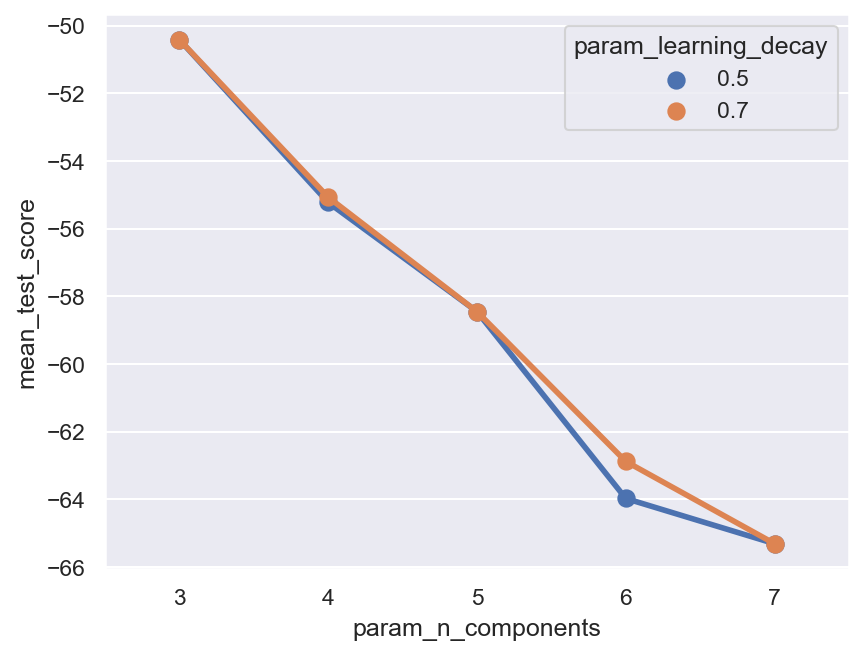

In [26]:
import seaborn as sns
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.pointplot(x="param_n_components",
              y="mean_test_score",
              hue="param_learning_decay",
              data=cv_results_df)

In [27]:
get_topics_meanings(best_lda.components_,
                    vocab,
                    display_weights=True,
                    weight_cutoff=2)

Topic #0 :
[('sky', 4.33), ('blue', 3.37), ('beautiful', 3.33)]
Topic #1 :
[('bacon', 2.33), ('eggs', 2.33), ('ham', 2.33), ('sausages', 2.33)]
Topic #2 :
[('brown', 3.33), ('dog', 3.33), ('fox', 3.33), ('lazy', 3.33), ('quick', 3.33)]


## Topic Prediction

- We can use our LDA to make predictions of topics for new documents.

In [28]:
new_texts = ['The sky is so blue', 'Love burger with ham']

new_texts_norm = normalize_corpus(new_texts)
new_texts_cv = cv.transform(new_texts_norm)
new_texts_cv.shape

(2, 20)

In [29]:
new_texts_doc_topic_matrix = best_lda.transform(new_texts_cv)
topics = ['weather', 'food', 'animal']
new_texts_doc_topic_df = pd.DataFrame(new_texts_doc_topic_matrix,
                                      columns=topics)
new_texts_doc_topic_df['predicted_topic'] = [
    topics[i] for i in np.argmax(new_texts_doc_topic_df.values, axis=1)
]

new_texts_doc_topic_df['corpus'] = new_texts_norm
new_texts_doc_topic_df

,weather,food,animal,predicted_topic,corpus
0,0.775601,0.111301,0.113098,weather,sky blue
1,0.123416,0.764964,0.111620,food,love burger ham


## Additional Notes

- We can calculate a metric to evaluate the coherence of each topic.
- The coherence computation is implemented in `gensim`. To apply the coherence comptuation to a `sklearn`-trained LDA, we need `tmtoolkit` (`tmtoolkit.topicmod.evaluate.metric_coherence_gensim`).

- I leave notes here in case in the future we need to compute the coherence metrics.

:::{warning}

`tmtoolkit` does not support `spacy` 3+. Also, `tmtoolkit` will downgrade several important packages to lower versions. Please use it with caution. I would suggest creating another virtual environment for this.

:::

- The following codes demonstrate how to find the optimal topic number based on the coherence scores of the topic models.

In [30]:
import tmtoolkit
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
def topic_model_coherence_generator(topic_num_start=2,
                                    topic_num_end=6,
                                    norm_corpus='',
                                    cv_matrix='',
                                    cv=''):
    norm_corpus_tokens = [doc.split() for doc in norm_corpus]
    models = []
    coherence_scores = []

    for i in range(topic_num_start, topic_num_end):
        print(i)
        cur_lda = LatentDirichletAllocation(n_components=i,
                                            max_iter=10000,
                                            random_state=0)
        cur_lda.fit_transform(cv_matrix)
        cur_coherence_score = metric_coherence_gensim(
            measure='c_v',
            top_n=5,
            topic_word_distrib=cur_lda.components_,
            dtm=cv.fit_transform(norm_corpus),
            vocab=np.array(cv.get_feature_names_out()),
            texts=norm_corpus_tokens)
        models.append(cur_lda)
        coherence_scores.append(np.mean(cur_coherence_score))
    return models, coherence_scores

In [31]:
%%time
ts = 2
te = 10
models, coherence_scores = topic_model_coherence_generator(
    ts, te, norm_corpus=norm_corpus, cv=cv, cv_matrix=cv_matrix)

2
3
4
5
6
7
8
9
CPU times: user 48 s, sys: 945 ms, total: 49 s
Wall time: 2min


In [32]:
coherence_scores

[0.6517493196892892,
 0.8866946211961687,
 0.765479848024043,
 0.8341252576008902,
 0.8572203857656319,
 0.7066394264220808,
 0.6391495323490347,
 0.6086551968156503]

In [33]:
coherence_df = pd.DataFrame({
    'TOPIC_NUMBER': [str(i) for i in range(ts, te)],
    'COHERENCE_SCORE': np.round(coherence_scores, 4)
})

coherence_df.sort_values(by=["COHERENCE_SCORE"], ascending=False)

,TOPIC_NUMBER,COHERENCE_SCORE
1,3,0.8867
4,6,0.8572
3,5,0.8341
2,4,0.7655
5,7,0.7066
0,2,0.6517
6,8,0.6391
7,9,0.6087


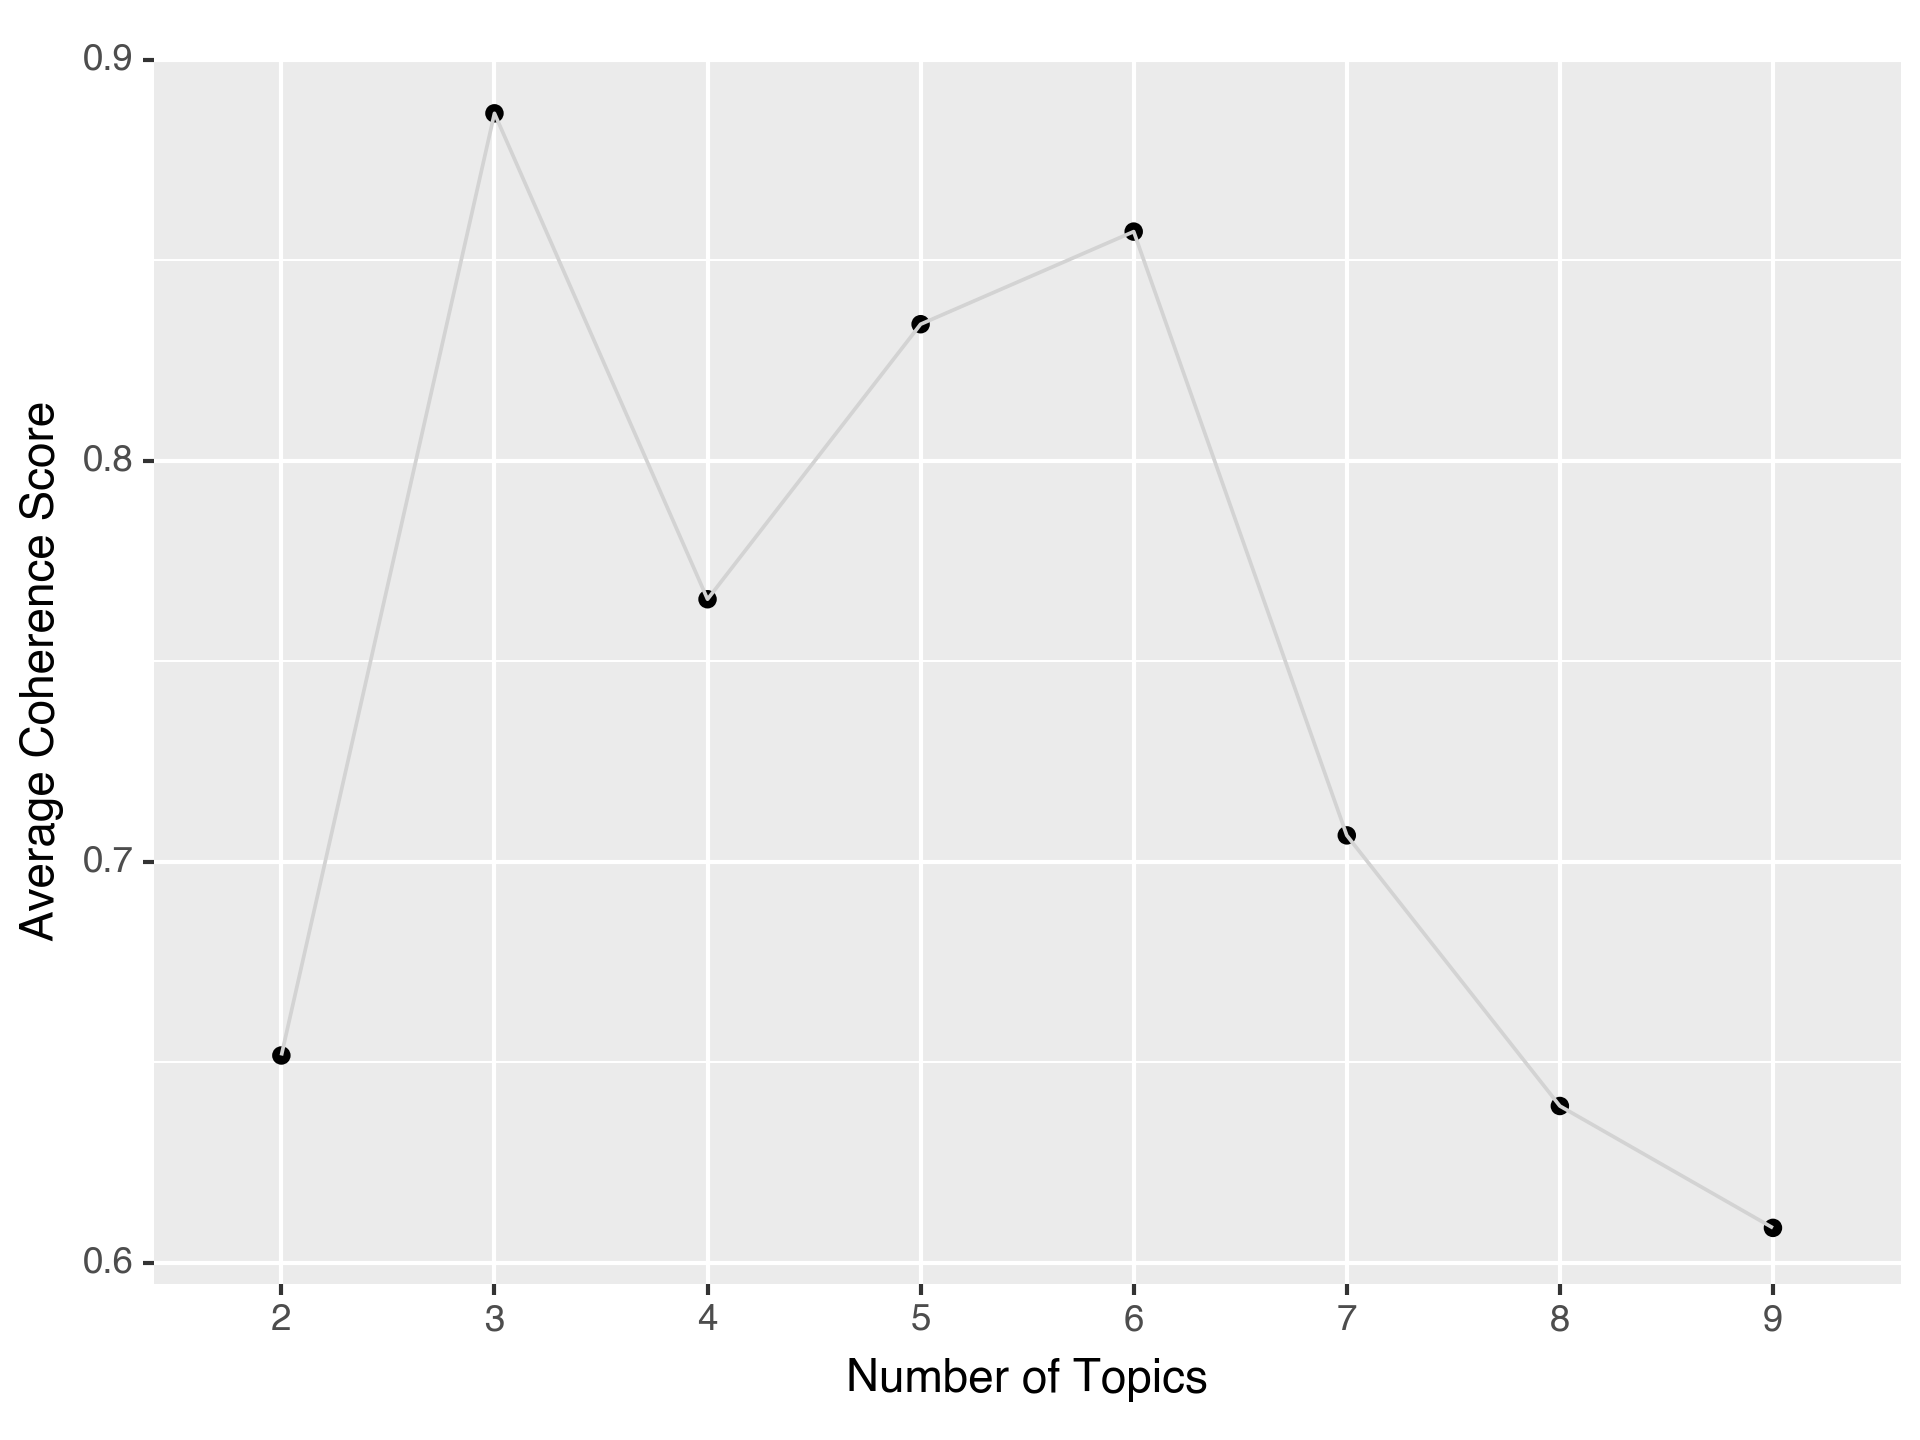

<Figure Size: (960 x 720)>

In [34]:
import plotnine
from plotnine import ggplot, aes, geom_point, geom_line, labs
plotnine.options.dpi = 150

g = (ggplot(coherence_df) + aes(x="TOPIC_NUMBER", y="COHERENCE_SCORE") +
     geom_point(stat="identity") + geom_line(group=1, color="lightgrey") +
     labs(x="Number of Topics", y="Average Coherence Score"))
g

## References

- Sarkar (2019), Chapter 6: Text Summarization and Topic Models